In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!unzip /content/drive/MyDrive/Eye-tracking/test_images_salicon.zip
!unzip /content/drive/MyDrive/Eye-tracking/train_images.zip
!unzip /content/drive/MyDrive/Eye-tracking/train_maps.zip
!unzip /content/drive/MyDrive/Eye-tracking/val_images.zip
!unzip /content/drive/MyDrive/Eye-tracking/val_maps.zip

In [ ]:
!git clone https://github.com/IgnatPolezhaev/Eye-tracking
%cd /content/Eye-tracking/TranSalNet

In [1]:
import os
import cv2
import time
import copy
import torch
import random
import pandas as pd
from skimage import io, transform
import numpy as np
from PIL import Image
import albumentations as A
import matplotlib.pyplot as plt
from IPython.display import clear_output
import torchvision.transforms.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from tqdm import tqdm

from utils.loss_function import SaliencyLoss
from utils.loss_function import AUC
from utils.data_process import MyDataset, MyTransform
from utils.data_process import preprocess_img, postprocess_img

flag = 2 # 0 for TranSalNet_Dense, 1 for TranSalNet_Res, 2 for TranSalNet_ViT

if flag == 0:
    from TranSalNet_Dense import TranSalNet
elif flag == 1:
    from TranSalNet_Res import TranSalNet
elif flag == 2:
    from TranSalNet_ViT import TranSalNet

In [2]:
colab = False

if colab:
    path_images_train = '/content/train_images/'
    path_images_val = '/content/val_images/'
    path_images_test = '/content/test_images_salicon/'

    path_maps_train = '/content/train_maps/'
    path_maps_val = '/content/val_maps/'

    path_train_ids = '/content/drive/MyDrive/Eye-tracking/TranSalNet/train_ids.csv'
    path_val_ids = '/content/drive/MyDrive/Eye-tracking/TranSalNet/val_ids.csv'
else:
    path_images_train = '/Users/ignatpolezhaev/Desktop/Игнат/Study/ФПМИ/Научка/code/datasets/train/train_images/'
    path_images_val = '/Users/ignatpolezhaev/Desktop/Игнат/Study/ФПМИ/Научка/code/datasets/val/val_images/'
    path_images_test = '/Users/ignatpolezhaev/Desktop/Игнат/Study/ФПМИ/Научка/code/datasets/test/test_images_salicon/'

    path_maps_train = '/Users/ignatpolezhaev/Desktop/Игнат/Study/ФПМИ/Научка/code/datasets/train/train_maps/'
    path_maps_val = '/Users/ignatpolezhaev/Desktop/Игнат/Study/ФПМИ/Научка/code/datasets/val/val_maps/'

    path_train_ids = '/Users/ignatpolezhaev/Desktop/Игнат/Study/ФПМИ/Научка/code/train_ids.csv'
    path_val_ids = '/Users/ignatpolezhaev/Desktop/Игнат/Study/ФПМИ/Научка/code/val_ids.csv'

In [3]:
print(len(os.listdir(path_images_train)))
print(len(os.listdir(path_images_test)))
print(len(os.listdir(path_images_val)))
print(len(os.listdir(path_maps_train)))
print(len(os.listdir(path_maps_val)))

10975
5000
5325
10975
5325


In [4]:
train_ids = pd.read_csv(path_train_ids)
val_ids = pd.read_csv(path_val_ids)
print(train_ids.iloc[1])
print(val_ids.iloc[1])

dataset_sizes = {'train':len(train_ids),'val':len(val_ids)}
print(dataset_sizes)

image    COCO_train2014_000000544819.jpg
map      COCO_train2014_000000544819.png
Name: 1, dtype: object
image    COCO_val2014_000000146457.jpg
map      COCO_val2014_000000146457.png
Name: 1, dtype: object
{'train': 10975, 'val': 5325}


In [5]:
batch_size = 4
shape_r = 288 #480
shape_c = 384 #640

p = 0.5
angles = [-30, -25, -20, -15, -10, -5, 5, 10, 15, 20, 25, 30]
train_transform = MyTransform(p=p, angles=angles, shape_r=shape_r, shape_c=shape_c, iftrain=True)
val_transform = MyTransform(p=p, angles=angles, shape_r=shape_r, shape_c=shape_c, iftrain=False)

train_set = MyDataset(ids=train_ids,
                      stimuli_dir=path_images_train,
                      saliency_dir=path_maps_train,
                      transform=train_transform)

val_set = MyDataset(ids=val_ids,
                    stimuli_dir=path_images_val,
                    saliency_dir=path_maps_val,
                    transform=val_transform)

dataloaders = {'train':DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4)
               ,'val':DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=4)}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([4, 3, 288, 384]) torch.Size([4, 1, 288, 384])


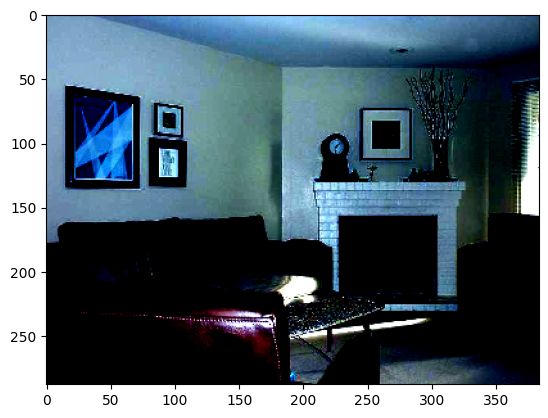

In [6]:
for item in dataloaders['train']:
    print(item['image'].shape, item['saliency'].shape)
    img = item['image'][0].squeeze()
    plt.imshow(img.permute(1, 2, 0))
    break

In [6]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = TranSalNet()
model = model.to(device)
print(f'The model has {count_parameters(model):,} trainable parameters')

/Users/ignatpolezhaev/Desktop/Игнат/Работа/Eye-tracking/et2/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ignatpolezhaev/Desktop/Игнат/Работа/Eye-tracking/et2/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Swin_T_Weights.IMAGENET1K_V1`. You can also use `weights=Swin_T_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


The model has 60,698,507 trainable parameters


# Train the model below

In [8]:
history_loss_train = []
history_loss_val = []

history_loss_train_cc = []
history_loss_train_sim = []
history_loss_train_kldiv = []
history_loss_train_nss = []
history_loss_train_auc = []

history_loss_val_cc = []
history_loss_val_sim = []
history_loss_val_kldiv = []
history_loss_val_nss = []
history_loss_val_auc = []

In [9]:
optimizer = optim.AdamW(model.parameters(), lr=1e-5)
scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

loss_fn = SaliencyLoss()

'''Training'''
best_model_wts = copy.deepcopy(model.state_dict())
num_epochs = 30
best_loss = 100
path_to_save = '/content/drive/MyDrive/Eye-tracking/TranSalNet/experiment_1'
#for k,v in model.named_parameters():
#    print('{}: {}'.format(k, v.requires_grad))

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch + 1, num_epochs))
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0

        # Iterate over data.
        for i_batch, sample_batched in tqdm(enumerate(dataloaders[phase])):
            stimuli, smap = sample_batched['image'], sample_batched['saliency']
            #stimuli, smap = stimuli.type(torch.cuda.FloatTensor), smap.type(torch.cuda.FloatTensor)
            stimuli, smap = stimuli.type(torch.float32), smap.type(torch.float32)
            stimuli, smap = stimuli.to(device), smap.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(stimuli)

                loss = -2*loss_fn(outputs,smap,loss_type='cc')
                loss = loss - loss_fn(outputs,smap,loss_type='sim')
                loss = loss + 10*loss_fn(outputs,smap,loss_type='kldiv')
                loss = loss - loss_fn(outputs,smap,loss_type='nss')

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # statistics
            if phase == 'train':
                history_loss_train.append(loss.item())
                history_loss_train_cc.append(loss_fn(outputs,smap,loss_type='cc').item())
                history_loss_train_sim.append(loss_fn(outputs,smap,loss_type='sim').item())
                history_loss_train_kldiv.append(loss_fn(outputs,smap,loss_type='kldiv').item())
                history_loss_train_nss.append(loss_fn(outputs,smap,loss_type='nss').item())
            else:
                history_loss_val.append(loss.item())
                history_loss_val_cc.append(loss_fn(outputs,smap,loss_type='cc').item())
                history_loss_val_sim.append(loss_fn(outputs,smap,loss_type='sim').item())
                history_loss_val_kldiv.append(loss_fn(outputs,smap,loss_type='kldiv').item())
                history_loss_val_nss.append(loss_fn(outputs,smap,loss_type='nss').item())

            running_loss += loss.item()

        if phase == 'train':
            scheduler.step()

        epoch_loss = running_loss / dataset_sizes[phase]

        print('{} Loss: {:.4f}'.format(phase, epoch_loss))

        if phase == 'val' and epoch_loss < best_loss:
            best_loss = epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            counter = 0
        elif phase == 'val' and epoch_loss >= best_loss:
            counter += 1
            if counter == 5:
                savepath = path_to_save + '/TranSalNet_ViT_'+str(epoch)+'.pth'
                torch.save(model.state_dict(), savepath)
                print('early stop!')
                break
            else:
                continue
    # saving weights
    if epoch%5 == 0:
        savepath = path_to_save + '/TranSalNet_ViT_'+str(epoch)+'.pth'
        torch.save(model.state_dict(), savepath)
        
    print()

print('Best val loss: {:4f}'.format(best_loss))
savepath = path_to_save + '/TranSalNet_ViT_'+str(epoch)+'.pth'
torch.save(model.state_dict(), savepath)
model.load_state_dict(best_model_wts)

Epoch 1/30
----------


0it [00:00, ?it/s]

x5  torch.Size([4, 768, 9, 12])
x5  torch.Size([4, 768, 18, 24])
x4_a  torch.Size([4, 768, 18, 24])
x4  torch.Size([4, 512, 36, 48])
x3_a  torch.Size([4, 512, 36, 48])
x3  torch.Size([4, 256, 72, 96])


1it [00:05,  5.62s/it]

x5  torch.Size([4, 768, 9, 12])
x5  torch.Size([4, 768, 18, 24])
x4_a  torch.Size([4, 768, 18, 24])
x4  torch.Size([4, 512, 36, 48])
x3_a  torch.Size([4, 512, 36, 48])
x3  torch.Size([4, 256, 72, 96])


2it [00:10,  5.00s/it]

x5  torch.Size([4, 768, 9, 12])
x5  torch.Size([4, 768, 18, 24])
x4_a  torch.Size([4, 768, 18, 24])
x4  torch.Size([4, 512, 36, 48])


2it [00:10,  5.46s/it]


KeyboardInterrupt: 

In [18]:
len_train = len(history_loss_train)
len_train_cc = len(history_loss_train_cc)
len_train_sim = len(history_loss_train_sim)
len_train_kldiv = len(history_loss_train_kldiv)
len_train_nss = len(history_loss_train_nss)

len_val = len(history_loss_val)
len_val_cc = len(history_loss_val_cc)
len_val_sim = len(history_loss_val_sim)
len_val_kldiv = len(history_loss_val_kldiv)
len_val_nss = len(history_loss_val_nss)

print(len_train, len_val)
print(len_train_cc, len_train_sim, len_train_kldiv, len_train_nss)
print(len_val_cc, len_val_sim, len_val_kldiv, len_val_nss)

24696 11988
24696 24696 24696 24696
11988 11988 11988 11988


In [23]:
history_loss_train_new = []
history_loss_train_cc_new = []
history_loss_train_sim_new = []
history_loss_train_kldiv_new = []
history_loss_train_nss_new = []

prev_i = 0
for i in range(len(history_loss_train)):
    if i%2744 == 0 and i != 0:
        history_loss_train_new.append(np.mean(history_loss_train[prev_i:i]))
        history_loss_train_cc_new.append(np.mean(history_loss_train_cc[prev_i:i]))
        history_loss_train_sim_new.append(np.mean(history_loss_train_sim[prev_i:i]))
        history_loss_train_kldiv_new.append(np.mean(history_loss_train_kldiv[prev_i:i]))
        history_loss_train_nss_new.append(np.mean(history_loss_train_nss[prev_i:i]))
        prev_i = i

history_loss_train_new.append(np.mean(history_loss_train[prev_i:-1]))
history_loss_train_cc_new.append(np.mean(history_loss_train_cc[prev_i:-1]))
history_loss_train_sim_new.append(np.mean(history_loss_train_sim[prev_i:-1]))
history_loss_train_kldiv_new.append(np.mean(history_loss_train_kldiv[prev_i:-1]))
history_loss_train_nss_new.append(np.mean(history_loss_train_nss[prev_i:-1]))

In [24]:
history_loss_val_new = []
history_loss_val_cc_new = []
history_loss_val_sim_new = []
history_loss_val_kldiv_new = []
history_loss_val_nss_new = []

prev_i = 0
for i in range(len(history_loss_val)):
    if i%1332 == 0 and i != 0:
        history_loss_val_new.append(np.mean(history_loss_val[prev_i:i]))
        history_loss_val_cc_new.append(np.mean(history_loss_val_cc[prev_i:i]))
        history_loss_val_sim_new.append(np.mean(history_loss_val_sim[prev_i:i]))
        history_loss_val_kldiv_new.append(np.mean(history_loss_val_kldiv[prev_i:i]))
        history_loss_val_nss_new.append(np.mean(history_loss_val_nss[prev_i:i]))
        prev_i = i

history_loss_val_new.append(np.mean(history_loss_val[prev_i:-1]))
history_loss_val_cc_new.append(np.mean(history_loss_val_cc[prev_i:-1]))
history_loss_val_sim_new.append(np.mean(history_loss_val_sim[prev_i:-1]))
history_loss_val_kldiv_new.append(np.mean(history_loss_val_kldiv[prev_i:-1]))
history_loss_val_nss_new.append(np.mean(history_loss_val_nss[prev_i:-1]))

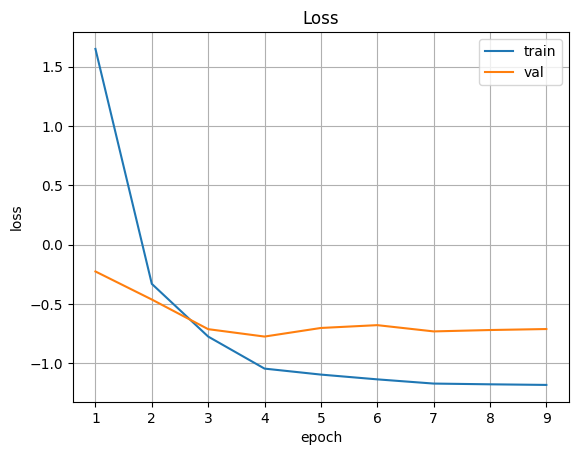

In [25]:
import matplotlib.pyplot as plt

fig = figsize=(8, 5)

plt.plot([1,2,3,4,5,6,7,8,9], history_loss_train_new, label='train')
plt.plot([1,2,3,4,5,6,7,8,9], history_loss_val_new, label='val')
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.show()

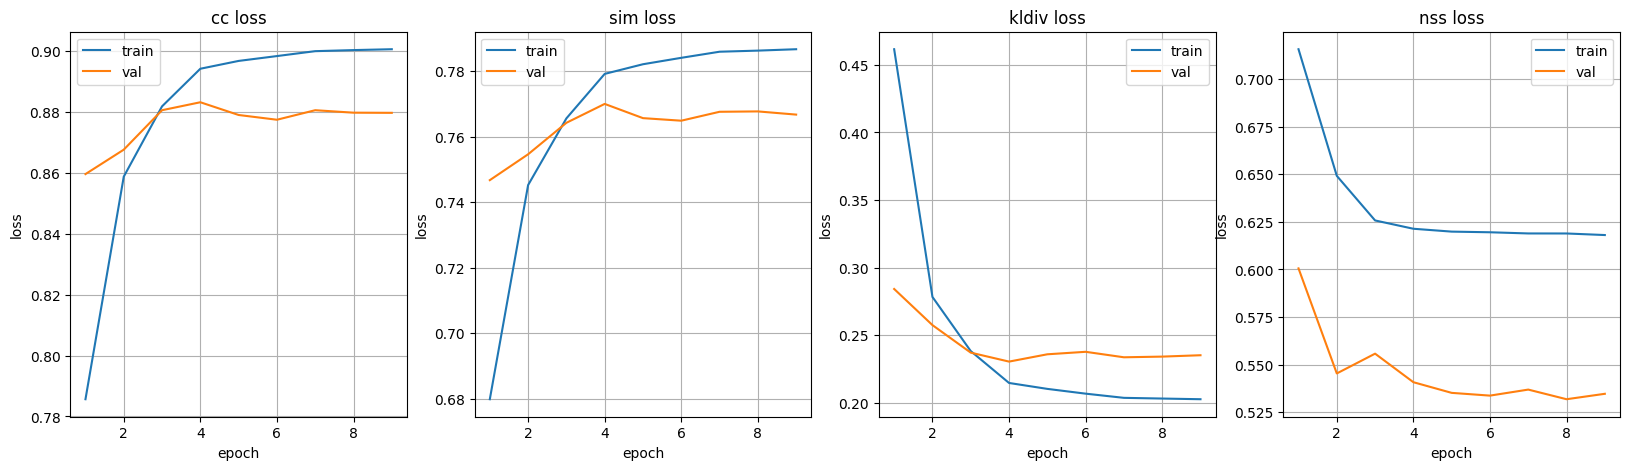

In [26]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))

ax[0].plot([1,2,3,4,5,6,7,8,9], history_loss_train_cc_new, label='train')
ax[0].plot([1,2,3,4,5,6,7,8,9], history_loss_val_cc_new, label='val')
ax[0].set_title('cc loss')
ax[0].grid()
ax[0].legend()
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')

ax[1].plot([1,2,3,4,5,6,7,8,9], history_loss_train_sim_new, label='train')
ax[1].plot([1,2,3,4,5,6,7,8,9], history_loss_val_sim_new, label='val')
ax[1].set_title('sim loss')
ax[1].grid()
ax[1].legend()
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('loss')

ax[2].plot([1,2,3,4,5,6,7,8,9], history_loss_train_kldiv_new, label='train')
ax[2].plot([1,2,3,4,5,6,7,8,9], history_loss_val_kldiv_new, label='val')
ax[2].set_title('kldiv loss')
ax[2].grid()
ax[2].legend()
ax[2].set_xlabel('epoch')
ax[2].set_ylabel('loss')

ax[3].plot([1,2,3,4,5,6,7,8,9], history_loss_train_nss_new, label='train')
ax[3].plot([1,2,3,4,5,6,7,8,9], history_loss_val_nss_new, label='val')
ax[3].set_title('nss loss')
ax[3].grid()
ax[3].legend()
ax[3].set_xlabel('epoch')
ax[3].set_ylabel('loss')

plt.show()

# Save the model below

In [27]:
savepath = 'TranSalNet_ViT_exp_1.pth'
torch.save(model.state_dict(), savepath)

# Submission

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Eye-tracking/TranSalNet/TranSalNet_ViT_1.pth'))
model.eval()
path_to_pred = '/content/images/test/'
list_to_pred = os.listdir(path_to_pred)

for i in tqdm(range(len(list_to_pred))):
    test_img = path_to_pred+list_to_pred[i]
    img = preprocess_img(test_img) # padding and resizing input image into 384x288
    img = np.array(img)/255.
    img = np.expand_dims(np.transpose(img,(2,0,1)),axis=0)
    img = torch.from_numpy(img)
    img = img.type(torch.cuda.FloatTensor).to(device)
    pred_saliency = model(img)
    toPIL = transforms.ToPILImage()
    pic = toPIL(pred_saliency.squeeze())
    #pred_saliency = pic.resize((384, 288))
    #pred_saliency.save('submit/'+list_to_pred[i].split('.')[0]+'.png')
    pred_saliency = postprocess_img(pic, test_img) # restore the image to its original size as the result
    cv2.imwrite('submit/'+list_to_pred[i].split('.')[0]+'.png', pred_saliency, [int(cv2.IMWRITE_JPEG_QUALITY), 100]) # save the result

100%|██████████| 5000/5000 [13:35<00:00,  6.13it/s]


# Show test

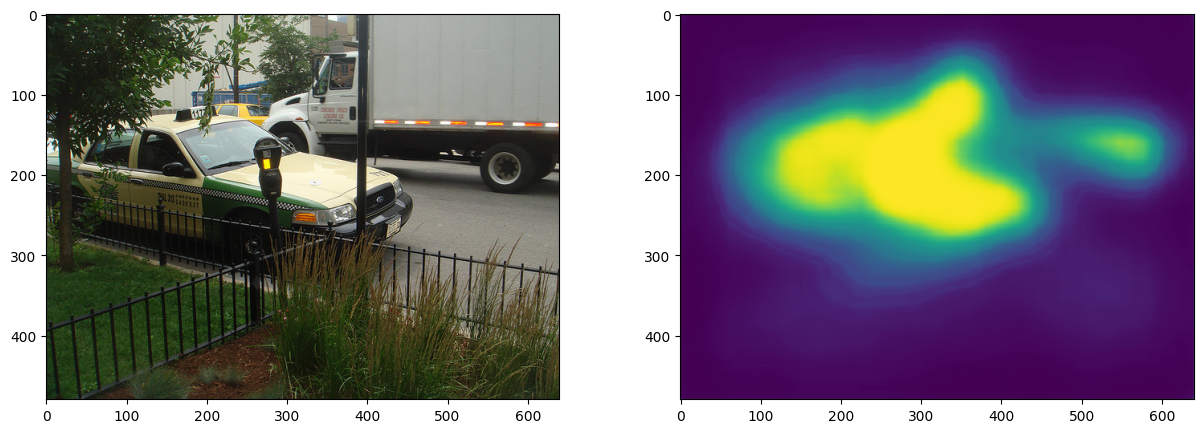

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

img_true = mpimg.imread('images/test/COCO_test2014_000000000001.jpg')
img_pred = mpimg.imread('submit/COCO_test2014_000000000001.png')
#imgplot = plt.imshow(img)

ax[0].imshow(img_true)
ax[1].imshow(img_pred)

plt.show()

# Show val

In [19]:
%cd /content

/content


FileNotFoundError: ignored

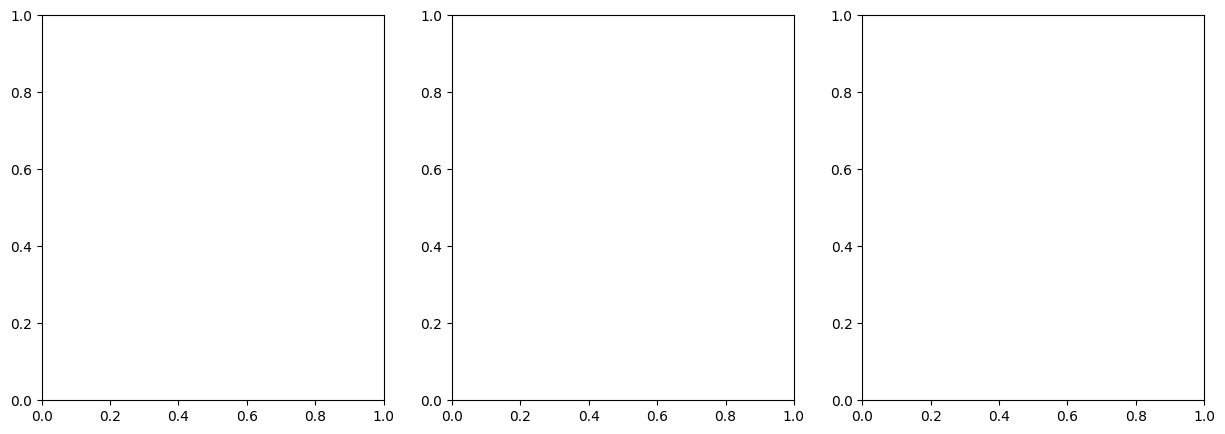

In [20]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

model.load_state_dict(torch.load('/content/drive/MyDrive/Eye-tracking/TranSalNet/TranSalNet_ViT_exp_1.pth'))
#model.load_state_dict(torch.load('/content/drive/MyDrive/Eye-tracking/TranSalNet/pretrained_models/TranSalNet_Dense.pth'))
model.eval()

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

num_pic = str('00000027478')

img_orig = mpimg.imread('/content/val_images/COCO_val2014_'+num_pic+'.jpg')
img_true = mpimg.imread('/content/val_maps/COCO_val2014_'+num_pic+'.png')
img = preprocess_img('/content/val_images/COCO_val2014_'+num_pic+'.jpg')
img = np.array(img)/255.
img = np.expand_dims(np.transpose(img,(2,0,1)),axis=0)
img = torch.from_numpy(img)
img = img.type(torch.cuda.FloatTensor).to(device)
pred_saliency = model(img)
toPIL = transforms.ToPILImage()
pic = toPIL(pred_saliency.squeeze())

ax[0].imshow(img_orig)
ax[0].set_title('Image')
ax[1].imshow(pic)
ax[1].set_title('Pred')
ax[2].imshow(img_true)
ax[2].set_title('True')

plt.show()
print(AUC(pred_saliency.squeeze().detach().cpu().numpy(), img_true))

In [13]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Eye-tracking/TranSalNet/TranSalNet_ViT_exp_1.pth'))
model.eval()

loss_fn = SaliencyLoss()

val_loss = 0.0
val_loss_cc = 0.0
val_loss_sim = 0.0
val_loss_kldiv = 0.0
val_loss_nss = 0.0
val_auc = 0.0

for i_batch, sample_batched in tqdm(enumerate(dataloaders['val'])):
    stimuli, smap = sample_batched['image'], sample_batched['saliency']
    stimuli, smap = stimuli.type(torch.cuda.FloatTensor), smap.type(torch.cuda.FloatTensor)
    stimuli, smap = stimuli.to(device), smap.to(device)

    with torch.no_grad():
        outputs = model(stimuli)

        b_s = stimuli.shape[0]
        batch_auc = 0.0
        for i in range(b_s):
            img_true = (smap[i].squeeze().cpu().detach().numpy()*255).astype(int)
            img_pred = (outputs[i].squeeze().cpu().detach().numpy()*255).astype(int)
            batch_auc += AUC(img_true, img_pred)
        batch_auc = batch_auc / b_s

        loss = -2*loss_fn(outputs,smap,loss_type='cc')
        loss = loss - loss_fn(outputs,smap,loss_type='sim')
        loss = loss + 10*loss_fn(outputs,smap,loss_type='kldiv')
        loss = loss - loss_fn(outputs,smap,loss_type='nss')

        val_loss += loss.item()
        val_loss_cc += loss_fn(outputs,smap,loss_type='cc').item()
        val_loss_sim += loss_fn(outputs,smap,loss_type='sim').item()
        val_loss_kldiv += loss_fn(outputs,smap,loss_type='kldiv').item()
        val_loss_nss += loss_fn(outputs,smap,loss_type='nss').item()
        val_auc += batch_auc

val_loss = val_loss / len(dataloaders['val'])
val_loss_cc = val_loss_cc / len(dataloaders['val'])
val_loss_sim = val_loss_sim / len(dataloaders['val'])
val_loss_kldiv = val_loss_kldiv / len(dataloaders['val'])
val_loss_nss = val_loss_nss / len(dataloaders['val'])
val_auc = val_auc / len(dataloaders['val'])

0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be co

OutOfMemoryError: ignored

In [ ]:
print('Loss = ', val_loss)
print('CC = ', val_loss_cc)
print('SIM = ', val_loss_sim)
print('KL = ', val_loss_kldiv)
print('NSS = ', val_loss_nss)
print('AUC = ', val_auc)

Loss =  -1.1077735204219818
CC =  0.8977498710155487
SIM =  0.7887441532611847
KL =  0.2048039227247238
NSS =  0.5715688530921936
AUC =  0.8549011046467453


TranSalNet_Dense

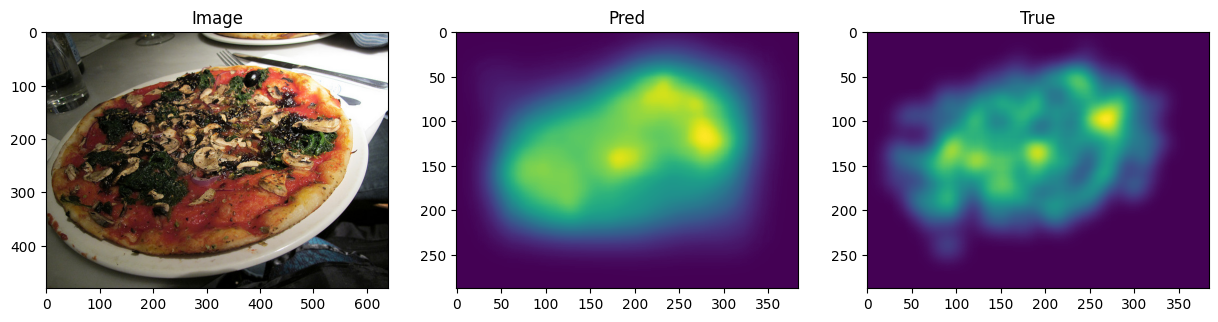

0.94173153953058


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#model.load_state_dict(torch.load('/content/drive/MyDrive/Eye-tracking/TranSalNet/TranSalNet_ViT_4.pth'))
model.load_state_dict(torch.load('/content/drive/MyDrive/Eye-tracking/TranSalNet/pretrained_models/TranSalNet_Dense.pth'))
model.eval()

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

num_pic = str('000000003192')
num_pic_other = str('000000000133')

img_orig = mpimg.imread('images/val/COCO_val2014_'+num_pic+'.jpg')

img = preprocess_img('images/val/COCO_val2014_'+num_pic+'.jpg')
img = np.array(img)/255.
img = np.expand_dims(np.transpose(img,(2,0,1)),axis=0)
img = torch.from_numpy(img)
img = img.type(torch.cuda.FloatTensor).to(device)
pred_saliency = model(img)
toPIL = transforms.ToPILImage()
pic = toPIL(pred_saliency.squeeze())

img_true = preprocess_img('/content/drive/MyDrive/Eye-tracking/TranSalNet/maps/val/COCO_val2014_'+num_pic+'.png')
img_true = np.array(img_true[:,:,0])/255.

ax[0].imshow(img_orig)
ax[0].set_title('Image')
ax[1].imshow(pic)
ax[1].set_title('Pred')
ax[2].imshow(img_true)
ax[2].set_title('True')

plt.show()
print(AUC(pred_saliency.squeeze().detach().cpu().numpy(), img_true))

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Eye-tracking/TranSalNet/pretrained_models/TranSalNet_Dense.pth'))
model.eval()

loss_fn = SaliencyLoss()

val_loss = 0.0
val_loss_cc = 0.0
val_loss_sim = 0.0
val_loss_kldiv = 0.0
val_loss_nss = 0.0
val_auc = 0.0

for i_batch, sample_batched in tqdm(enumerate(dataloaders['val'])):
    stimuli, smap = sample_batched['image'], sample_batched['saliency']
    stimuli, smap = stimuli.type(torch.cuda.FloatTensor), smap.type(torch.cuda.FloatTensor)
    stimuli = F.resize(stimuli, (shape_r, shape_c))
    smap = F.resize(smap, (shape_r, shape_c))
    stimuli, smap = stimuli.to(device), smap.to(device)

    with torch.no_grad():
        outputs = model(stimuli)

        b_s = stimuli.shape[0]
        batch_auc = 0.0
        for i in range(b_s):
            img_true = (smap[i].squeeze().cpu().detach().numpy()*255).astype(int)
            img_pred = (outputs[i].squeeze().cpu().detach().numpy()*255).astype(int)
            batch_auc += AUC(img_true, img_pred)
        batch_auc = batch_auc / b_s

        loss = -2*loss_fn(outputs,smap,loss_type='cc')
        loss = loss - loss_fn(outputs,smap,loss_type='sim')
        loss = loss + 10*loss_fn(outputs,smap,loss_type='kldiv')
        loss = loss - loss_fn(outputs,smap,loss_type='nss')

        val_loss += loss.item()
        val_loss_cc += loss_fn(outputs,smap,loss_type='cc').item()
        val_loss_sim += loss_fn(outputs,smap,loss_type='sim').item()
        val_loss_kldiv += loss_fn(outputs,smap,loss_type='kldiv').item()
        val_loss_nss += loss_fn(outputs,smap,loss_type='nss').item()
        val_auc += batch_auc

val_loss = val_loss / len(dataloaders['val'])
val_loss_cc = val_loss_cc / len(dataloaders['val'])
val_loss_sim = val_loss_sim / len(dataloaders['val'])
val_loss_kldiv = val_loss_kldiv / len(dataloaders['val'])
val_loss_nss = val_loss_nss / len(dataloaders['val'])
val_auc = val_auc / len(dataloaders['val'])

1250it [05:14,  3.97it/s]


In [ ]:
print('Loss = ', val_loss)
print('CC = ', val_loss_cc)
print('SIM = ', val_loss_sim)
print('KL = ', val_loss_kldiv)
print('NSS = ', val_loss_nss)
print('AUC = ', val_auc)

Loss =  -1.2692392374515533
CC =  0.9079972919464111
SIM =  0.8008252229690552
KL =  0.18879408804178238
NSS =  0.5403603088378907
AUC =  0.8746099382741082


TranSalNet_ResNet

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#model.load_state_dict(torch.load('/content/drive/MyDrive/Eye-tracking/TranSalNet/TranSalNet_ViT_4.pth'))
model.load_state_dict(torch.load('/content/drive/MyDrive/Eye-tracking/TranSalNet/pretrained_models/TranSalNet_Dense.pth'))
model.eval()

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

num_pic = str('000000003192')
num_pic_other = str('000000000133')

img_orig = mpimg.imread('images/val/COCO_val2014_'+num_pic+'.jpg')

img = preprocess_img('images/val/COCO_val2014_'+num_pic+'.jpg')
img = np.array(img)/255.
img = np.expand_dims(np.transpose(img,(2,0,1)),axis=0)
img = torch.from_numpy(img)
img = img.type(torch.cuda.FloatTensor).to(device)
pred_saliency = model(img)
toPIL = transforms.ToPILImage()
pic = toPIL(pred_saliency.squeeze())

img_true = preprocess_img('/content/drive/MyDrive/Eye-tracking/TranSalNet/maps/val/COCO_val2014_'+num_pic+'.png')
img_true = np.array(img_true[:,:,0])/255.

ax[0].imshow(img_orig)
ax[0].set_title('Image')
ax[1].imshow(pic)
ax[1].set_title('Pred')
ax[2].imshow(img_true)
ax[2].set_title('True')

plt.show()
print(AUC(pred_saliency.squeeze().detach().cpu().numpy(), img_true))

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Eye-tracking/TranSalNet/pretrained_models/TranSalNet_Res.pth'))
model.eval()

loss_fn = SaliencyLoss()

val_loss = 0.0
val_loss_cc = 0.0
val_loss_sim = 0.0
val_loss_kldiv = 0.0
val_loss_nss = 0.0
val_auc = 0.0

for i_batch, sample_batched in tqdm(enumerate(dataloaders['val'])):
    stimuli, smap = sample_batched['image'], sample_batched['saliency']
    stimuli, smap = stimuli.type(torch.cuda.FloatTensor), smap.type(torch.cuda.FloatTensor)
    stimuli = F.resize(stimuli, (shape_r, shape_c))
    smap = F.resize(smap, (shape_r, shape_c))
    stimuli, smap = stimuli.to(device), smap.to(device)

    with torch.no_grad():
        outputs = model(stimuli)

        b_s = stimuli.shape[0]
        batch_auc = 0.0
        for i in range(b_s):
            img_true = (smap[i].squeeze().cpu().detach().numpy()*255).astype(int)
            img_pred = (outputs[i].squeeze().cpu().detach().numpy()*255).astype(int)
            batch_auc += AUC(img_true, img_pred)
        batch_auc = batch_auc / b_s

        loss = -2*loss_fn(outputs,smap,loss_type='cc')
        loss = loss - loss_fn(outputs,smap,loss_type='sim')
        loss = loss + 10*loss_fn(outputs,smap,loss_type='kldiv')
        loss = loss - loss_fn(outputs,smap,loss_type='nss')

        val_loss += loss.item()
        val_loss_cc += loss_fn(outputs,smap,loss_type='cc').item()
        val_loss_sim += loss_fn(outputs,smap,loss_type='sim').item()
        val_loss_kldiv += loss_fn(outputs,smap,loss_type='kldiv').item()
        val_loss_nss += loss_fn(outputs,smap,loss_type='nss').item()
        val_auc += batch_auc

val_loss = val_loss / len(dataloaders['val'])
val_loss_cc = val_loss_cc / len(dataloaders['val'])
val_loss_sim = val_loss_sim / len(dataloaders['val'])
val_loss_kldiv = val_loss_kldiv / len(dataloaders['val'])
val_loss_nss = val_loss_nss / len(dataloaders['val'])
val_auc = val_auc / len(dataloaders['val'])

1250it [04:13,  4.93it/s]


In [ ]:
print('Loss = ', val_loss)
print('CC = ', val_loss_cc)
print('SIM = ', val_loss_sim)
print('KL = ', val_loss_kldiv)
print('NSS = ', val_loss_nss)
print('AUC = ', val_auc)

Loss =  -1.1107271119832993
CC =  0.90102661652565
SIM =  0.7945347722053527
KL =  0.20219380984306334
NSS =  0.5360772109985351
AUC =  0.8715374151198656
